In [42]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import skimage.io
import torch
import os
import cv2
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from torchvision import transforms

In [6]:
class config:
    debug=False
    lr=1e-4
    batch_size=16
    epochs=20 # you can train more epochs
    seed=777
    target_size=6
    target_col='isup_grade'
    n_fold=4

In [8]:
train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
test_df = pd.read_csv('../input/prostate-cancer-grade-assessment/test.csv')
sample_submission_df = pd.read_csv('../input/prostate-cancer-grade-assessment/sample_submission.csv')
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [19]:
def tile_patriot(img, sz=128, N=16):
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    return img#[N,size,size,3]

## Test for single Image

In [38]:
# names = [name[:-10] for name in os.listdir(MASKS)]
# single_file_name = names[1]
# single_img = skimage.io.MultiImage(os.path.join(TRAIN,single_file_name+".tiff"))[-1]     # -1 since we want last downsized one 
# single_mask_img =skimage.io.MultiImage(os.path.join(MASKS,single_file_name+'_mask.tiff'))[-1]

# images_patriot = tile_patriot(single_img, sz=128, N=16)
# images_lafoss  = tile_lafoss(single_img,single_mask_img)

# for image in images_patriot:
#     print(image.shape)
    
# for image in images_lafoss:
#     print(image['img'].shape)

## DataSet 

In [33]:
class BiopsyDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
#         names = [name[:-10] for name in os.listdir(MASKS)]
        file_name = self.df['image_id'].values[idx]
        file_path = f'../input/prostate-cancer-grade-assessment/train_images/{file_name}.tiff'
        image = skimage.io.MultiImage(file_path)[-1]
        image = tile_patriot(image, sz=128, N=16)
        image = cv2.hconcat([cv2.vconcat([image[0], image[1], image[2], image[3]]), 
                             cv2.vconcat([image[4], image[5], image[6], image[7]]), 
                             cv2.vconcat([image[8], image[9], image[10], image[11]]), 
                             cv2.vconcat([image[12], image[13], image[14], image[15]])])
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        label = torch.tensor(self.labels[idx]).float()
        
        return image, label

# Data Loader

In [39]:
train_dataset = BiopsyDataset(train_df, train_df[config.target_col], transform=None)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [40]:
len(train_loader)

332

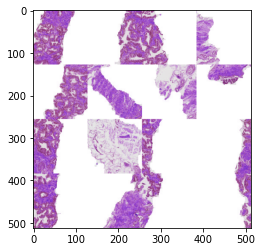

In [41]:
for image, label in train_loader:
    plt.imshow(image[0])
    plt.show()  
    break

In [43]:
def get_transforms(*, data):
    
    assert data in ('train', 'valid')
    
    if data == 'train':
        return Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# Train Validation Split

In [44]:
if config.debug:
    folds = train_df.sample(n=1000, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds = train_df.copy()

In [ ]:
train_labels = folds[config.target_col].values
kf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
    folds.loc[val_index, 'fold'] = int(fold)
folds['fold'] = folds['fold'].astype(int)
folds.to_csv('folds.csv', index=None)
folds.head()

In [ ]:
trn_idx = folds[folds['fold'] != 0].index
val_idx = folds[folds['fold'] == 0].index

In [ ]:
train_dataset = TrainDataset(folds.loc[trn_idx].reset_index(drop=True), 
                                 folds.loc[trn_idx].reset_index(drop=True)[config.target_col], 
                                 transform=None)
valid_dataset = TrainDataset(folds.loc[val_idx].reset_index(drop=True), 
                             folds.loc[val_idx].reset_index(drop=True)[config.target_col], 
                             transform=None)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4)

### Trying new approach